In [6]:
import sys
import numpy as np
import torch
print(torch.cat((torch.Tensor(np.array([0,1])), torch.Tensor(np.array([0,1])), torch.Tensor([0.9]))))




# sys.path.insert(0,"..")
from dataloader import dataloader
tmp = dataloader(r"..\data\clover",1)
imu, rotor, mocap = tmp.runPipeline()
tmp.homogenizeData()
data = tmp.ConcatData

tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.9000])


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


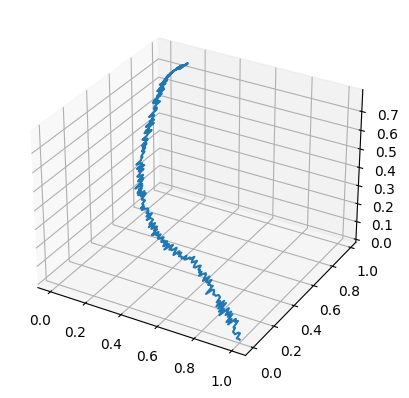

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

x1,y1,z1 = data['pose.position.x'].to_numpy(),data['pose.position.y'].to_numpy(),data['pose.position.z'].to_numpy()
xA1,yA1,zA1 = data['psi'].to_numpy(),data['theta'].to_numpy(),data['phi'].to_numpy()
t = data['Time'].to_numpy()
r1, r2, r3, r4 = data['rpm_0'].to_numpy(), data['rpm_1'].to_numpy(), data['rpm_2'].to_numpy(), data['rpm_3'].to_numpy()

size = 1000
TrainSize = 800
St = 68000
t = t - t[St]

scaler_X = MinMaxScaler(feature_range=(0, 1))
xTrain = np.stack((r1[St:St + size],r2[St:St + size],r3[St:St + size],r4[St:St + size], t[St:St + size]),axis=1)
yTrain = np.stack((x1[St:St + size],xA1[St:St + size],y1[St:St + size],yA1[St:St + size],z1[St:St + size],zA1[St:St + size]),axis=1)

xTrain = scaler_X.fit_transform(xTrain)
yTrain = scaler_X.fit_transform(yTrain)

train_x = xTrain[:TrainSize]#torch.tensor(xTrain[:7000], dtype=torch.float32)
train_y = yTrain[:TrainSize]#torch.tensor(yTrain[:7000], dtype=torch.float32)
test_x = xTrain[TrainSize:]#torch.tensor(xTrain[7000:], dtype=torch.float32)
test_y = yTrain[TrainSize:]#torch.tensor(yTrain[7000:], dtype=torch.float32)

ax = plt.figure().add_subplot(projection='3d')
ax.plot(train_y[:,0],train_y[:,1],train_y[:,2])

In [3]:
#### NODE #####

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib.pyplot as plt

method = 'dopri5'
batch_time = 45
batch_size = TrainSize-100
niters = 2000
test_freq = 100
viz = 'store_true'
adjoint = 'store_true'

def mini_batch(yTrain, xTrain, size, batch_size, batch_time):
        
    s = torch.from_numpy(np.random.choice(np.arange(size-batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = xTrain[s,:4]
    batch_x = xTrain[:batch_time,4] 
    batch_y = torch.stack([torch.Tensor(xTrain[s + i,:4]) for i in range(batch_time)], dim=0)
    batch_yy = yTrain[s,:]
    batch_yy1 = yTrain[s+1,:]

    return batch_y0, batch_x, batch_y, batch_yy, batch_yy1

def TrainNODENetwork(yTrain, xTrain, size, batch_size, batch_time, FuncControl, FuncDynamics, niters=13000,):

    parameters = list(FuncControl.parameters()) + list(FuncDynamics.parameters())
    #optimizerD = optim.Adam(params=parameters, lr=1e-3)
    optimizer = optim.Adadelta(params=parameters, lr=1, rho=0.9, eps=1e-06, weight_decay=0) #

    for itr in range(1,niters +1):
        optimizer.zero_grad()    
        batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(yTrain, xTrain, size, batch_size, batch_time)
        pred_y = odeint(FuncControl, torch.Tensor(batch_y0), torch.Tensor(batch_x))
        
        XDynamics = torch.cat((torch.Tensor(batch_y0), torch.Tensor(batch_yy)), 1).to(device='cuda:0') #pred_y[1,:,:]
        pred_yy = FuncDynamics(XDynamics).to(device='cuda:0')
        lossD = torch.mean(torch.abs(pred_yy - torch.Tensor(batch_yy1).to(device='cuda:0')))
        #lossC = torch.mean(torch.abs(pred_y - torch.Tensor(batch_y)))

        loss = lossD# + lossC
        loss.backward()
        optimizer.step()

        if itr % test_freq == 0:
            '''with torch.no_grad():
                pred_y = odeint(Func, torch.Tensor(y0[1,:]), t)
                loss = torch.norm(pred_y - torch.Tensor(y[:,1,:]))'''
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
    
    return FuncControl, FuncDynamics

class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 4),
        )
        self.net = self.net.float()
        self.net.apply(self._apply_wt_init)

    def forward(self, t, y):
        return self.net(y)
    
    def _apply_wt_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, val=0)

class Func2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 75),
            nn.Tanh(),
            nn.Linear(75, 35),
            nn.Tanh(),
            nn.Linear(35, 6),
        )
        self.net = self.net.float()
        self.net.apply(self._apply_wt_init)

    def forward(self, y):
        return self.net(y)
    
    def _apply_wt_init(self, layer):
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, val=0)

FuncControl = ODEFunc()
FuncDynamics = Func2().to(device='cuda:0')

FuncControl, FuncDynamics = TrainNODENetwork(train_y, train_x, TrainSize, batch_size, batch_time, FuncControl, FuncDynamics)

Iter 0100 | Total Loss 0.079991
Iter 0200 | Total Loss 0.069242
Iter 0300 | Total Loss 0.051543
Iter 0400 | Total Loss 0.064254
Iter 0500 | Total Loss 0.042391
Iter 0600 | Total Loss 0.035017
Iter 0700 | Total Loss 0.036976
Iter 0800 | Total Loss 0.040695
Iter 0900 | Total Loss 0.035767
Iter 1000 | Total Loss 0.036041
Iter 1100 | Total Loss 0.032216
Iter 1200 | Total Loss 0.028065
Iter 1300 | Total Loss 0.031747
Iter 1400 | Total Loss 0.030576
Iter 1500 | Total Loss 0.027858
Iter 1600 | Total Loss 0.026383
Iter 1700 | Total Loss 0.029213
Iter 1800 | Total Loss 0.030636
Iter 1900 | Total Loss 0.031692
Iter 2000 | Total Loss 0.025256
Iter 2100 | Total Loss 0.024203
Iter 2200 | Total Loss 0.021414
Iter 2300 | Total Loss 0.025408
Iter 2400 | Total Loss 0.025104
Iter 2500 | Total Loss 0.026565
Iter 2600 | Total Loss 0.025390
Iter 2700 | Total Loss 0.025584
Iter 2800 | Total Loss 0.026247
Iter 2900 | Total Loss 0.022740
Iter 3000 | Total Loss 0.023161
Iter 3100 | Total Loss 0.021577
Iter 320

In [9]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
ax.plot(train_y[:,0],train_y[:,1],train_y[:,2], color='red')

y0 = train_y[0,:]
u0 = train_x[0,:4]
FuncDynamics.eval()
for i in range(TrainSize):  

    #pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))
    u0 = train_x[i,:4]#pred_u[1,:].detach().numpy()
    m = train_y[i,:]
    m[:3] += (np.random.uniform()-0.5)*3
    XDynamics = torch.cat((torch.Tensor(u0), torch.Tensor(m)).to(device='cuda:0')
    pred_y = FuncDynamics(XDynamics)
    y0 = pred_y.to('cpu').detach().numpy()
    ax.scatter(y0[0], y0[1],y0[2], s=8,c='b')

SyntaxError: unmatched ')' (1450763858.py, line 13)

In [8]:
train_y[i,:] + (np.random.uniform()-0.5)*3

array([1.36037796, 2.07755104, 1.97238808, 1.22104869, 1.70708212,
       1.77801523])